# 설치 파일

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# import

In [2]:
!pip install shap

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.5 MB/s eta 0:00:00


# 데이터 불러오기

In [17]:
file_path = 'train_OutlierRemoval.csv'
data = pd.read_csv(file_path)

# Drop unnecessary columns and split into X and y
X = data.drop(['label', 'Unnamed: 0', 'ID','콜레스테롤'], axis=1)
y = data['label']

# 원래 피처 이름을 저장
feature_names = X.columns

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.head()

,나이,키(cm),몸무게(kg),시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율
1612,55,145,45,0.90,0,95,46.0,88,0.8,93.000000,207.0,13.5,1,1.14
978,55,160,55,0.50,0,94,42.0,107,0.7,100.876263,81.0,14.6,1,1.15
3050,40,170,60,1.35,0,102,28.0,230,1.0,40.000000,157.0,16.0,1,1.60
4960,55,165,55,0.90,1,101,54.0,47,0.9,54.000000,124.0,12.8,1,1.11
2548,60,170,65,1.00,0,98,40.0,173,0.9,25.000000,55.0,15.8,1,0.88


# 데이터 스케일링

In [8]:
# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 모델링

In [9]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 모델 정의
rf_model = RandomForestClassifier()

# 하이퍼파라미터 튜닝을 위한 그리드 설정
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


# GridSearchCV를 사용한 하이퍼파라미터 튜닝
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5, verbose=2, n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [10]:
# 최적의 모델로 예측
best_model = rf_grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# 최적의 파라미터 출력
print("Best parameters found: ", rf_grid.best_params_)
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_proba))


Best parameters found:  {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
ROC AUC Score:  0.7984155956440889


# 성능평가

In [11]:
# 성능평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'정확도: {accuracy}')
print(f'정밀도: {precision}')
print(f'재현율: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')


정확도: 0.7252380952380952
정밀도: 0.6201550387596899
재현율: 0.6290956749672346
F1 Score: 0.6245933636955107
ROC AUC: 0.7984155956440889


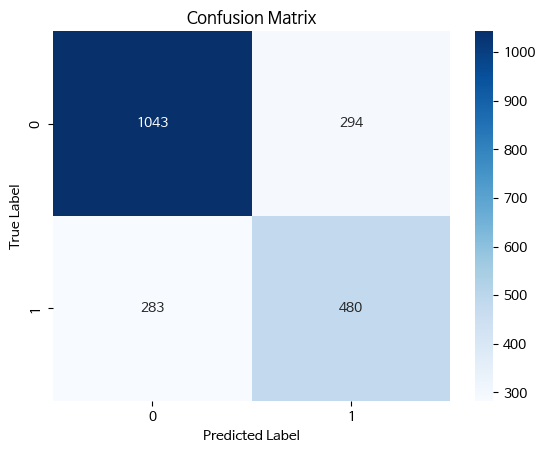

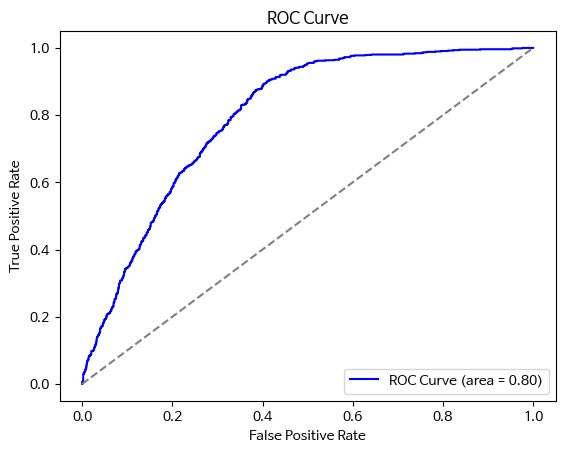

In [12]:
# 혼돈행렬
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 교차 검증

In [13]:


# K-fold 교차 검증
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(best_model, X_train_scaled, y_train, cv=kf, scoring='accuracy')

print(f'Cross-Validation accuracy scores: {cv_results}')
print(f'Mean accuracy: {cv_results.mean():.4f}')

Cross-Validation accuracy scores: [0.7244898  0.75102041 0.72857143 0.73367347 0.73673469]
Mean accuracy: 0.7349


# 피처 중요도

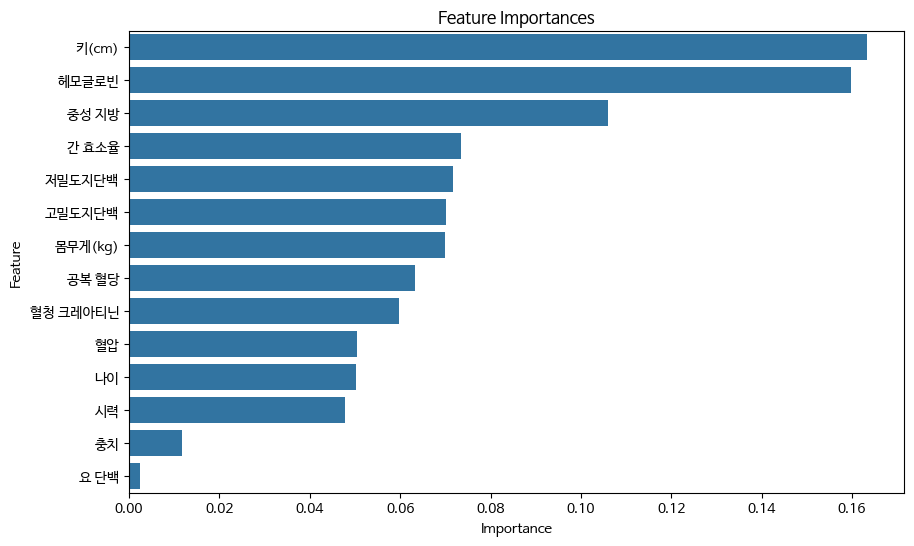

In [14]:
# Feature importance
feature_importances = best_model.feature_importances_

feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# SHAP

In [18]:
# Explainer 생성

explainer = shap.Explainer(best_model, X_train_scaled)

# SHAP 값 계산
shap_values = explainer(X_train_scaled)

shap.summary_plot(shap_values, features=X_train_scaled, feature_names=feature_names)

# Summary plot
shap.summary_plot(shap_values, X_test_scaled)

# Summary plot (bar plot)
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

100%|===================| 9782/9800 [05:58<00:00]       

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.810154, while the model output was 0.794619. If this difference is acceptable you can set check_additivity=False to disable this check.

In [ ]:
!pip install scikit-learn shap


In [ ]:
import shap

# KernelExplainer 생성
explainer = shap.KernelExplainer(best_model.predict, X_train)
# SHAP 값 계산
shap_values = explainer.shap_values(X_test, nsamples=100)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Summary plot (bar plot)
shap.summary_plot(shap_values, X_test, plot_type="bar")
